In [25]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import math
from itertools import product
from glob import glob

## Data not included
Grabbed data from citibike urls, have to add data retrieval steps, consult https://github.com/toddwschneider/nyc-citibike-data

### Cheated with speed and distance. I just comput distance and speed by adding together change in Latitude to the Change in Longitude.  

In [343]:
def readCSV(csv):
    d = pd.read_csv(csv,
                parse_dates = ['starttime','stoptime'],
                infer_datetime_format = True)
    d.columns = ['tripdur','st','et','ssid','ssname','sslat','sslon',
            'esid','esname','eslat','eslon','bikeid','usertype','yob','gender']
    d['age'] = d['st'].apply(lambda x: x.year) - d.yob
    # convert from degrees to miles, 
    d['ns'] = (d.eslat - d.sslat)*69.172
    # the distance of longitudintal degrees vary with latidute, employ a quick transformation.
    d['ew'] = (d.eslon - d.sslon)*(math.cos(40.7648 *(math.pi/180)) * 69.172)
    d['psuedospeed'] = (d.ns.abs()+d.ew.abs()) / (d.tripdur/3600)
    d['psuedodistance'] = d.ns.abs()+d.ew.abs()
    # break start and stop times into 5 minute intervals
    ns5min=5*60*1000000000   # 5 minutes in nanoseconds 
    d['st5min'] = pd.to_datetime(((d.st.astype(np.int64) // ns5min + 1 ) * ns5min))
    d['et5min'] = pd.to_datetime(((d.et.astype(np.int64) // ns5min + 1 ) * ns5min))
    return d


In [341]:
# we have som garbage in here
csvpaths = glob('data/2015*csv')
spd = np.copy(t)
dist = np.copy(t)
for i,csv in enumerate(csvpaths):
    d = readCSV(csv)
    grp = d.groupby(by=[d.st5min.map(lambda x : int(x.hour*60 + x.minute))])
    x = pd.to_timedelta(grp.psuedodistance.mean().index.values/60, unit='m')
    t[:,i] = x
    spd[:,i] = grp.psuedospeed.mean()
    dist[:,i] = grp.psuedodistance.mean()


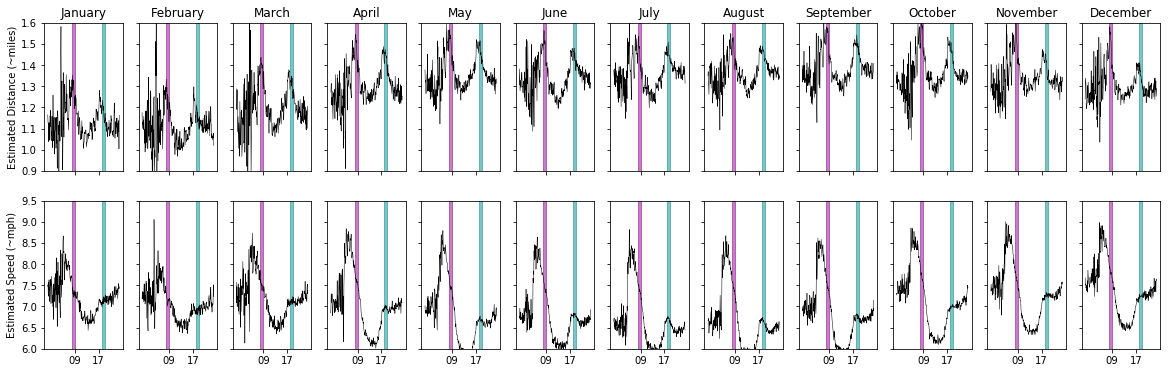

In [356]:
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import calendar
# we have som garbage in here
def timeTicks(x, pos): 
    d = datetime.timedelta(milliseconds=x/1000000)                                                                                                                                                                                                                                          
    return str(d)[2:4]                                                                                                                                                                                                                                                             
formatter = mpl.ticker.FuncFormatter(timeTicks) 

f, axar = plt.subplots(2,len(csvpaths), sharey='row', sharex='col')
for i,csv in enumerate(csvpaths):
    axar[0,i].plot(x,dist[:,i],'-k',linewidth=0.5)
    axar[1,i].plot(x,spd[:,i],'-k',linewidth=0.5)
    axar[0,i].set_title(calendar.month_name[i+1])
    
for ax in axar.flatten():
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    amrush = 8*60*10**9
    pmrush = 18*60*10**9
    amrect = patches.Rectangle((amrush,0), width=60*10**9, height=1,
                         transform=trans, color='darkmagenta',
                         alpha=0.5)
    pmrect = patches.Rectangle((pmrush,0), width=60*10**9, height=1,
                         transform=trans, color='darkcyan',
                         alpha=0.5)
    [ax.add_patch(rect) for rect in [amrect,pmrect]]
    axar[0,i]
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_ticks([9*60*10**9,17*60*10**9])
    ax.set_title
axar[0,0].set_ylabel("Estimated Distance (~miles)")
axar[1,0].set_ylabel("Estimated Speed (~mph)")
[ax.set_ylim(0.9,1.6) for ax in axar[0,:]]
[ax.set_ylim(6,9.5) for ax in axar[1,:]]    
f.set_size_inches(20,6)
f.savefig('CartesianDistance.pdf')

You can see that there are peaks in the distance traveled around the beginning (magenta) and the end (cyan) of the work day (top row). Interestingly, there is a not a cooresponding pattern in the speed of travel about the work day. There is a clear peak in speed before the beginining of work, and a substantial slowing in the middle of the day. At the end of the work day, trips are faster than in the middle of the day, but not nearly as fast as in the morning. This pattern is observed throughout the year, but is more pronounced in the summer months, indicating a interaction with temperature (I am considering time of day as a proxy for temperature)

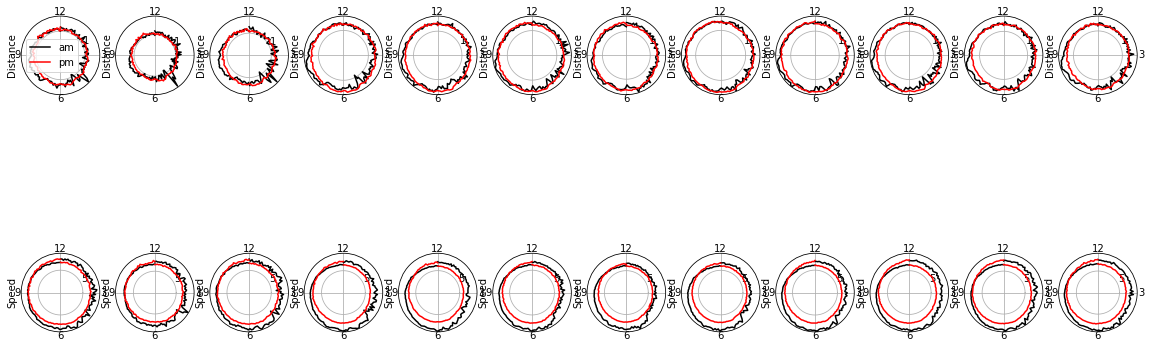

In [324]:
f, axar = plt.subplots(2,len(csvpaths), subplot_kw=dict(projection='polar'))
st,m,e = (0,int((24*60/5)//2), int((24*60/5)))
tm = np.linspace(2.5*np.pi,0.5*np.pi,int((24*60/5)//2))
labels={'black':'am',
       'red':'pm'}
for i,csv in enumerate(csvpaths):
    for s, col in zip([slice(st,m),slice(m,e)],['black','red']):
        axar[0,i].plot(tm,dist[:,i][s],color = col,label = labels[col])
        axar[1,i].plot(tm,spd[:,i][s],color = col)
        
[ax.set_xticks([0,np.pi/2,np.pi,np.pi*3/2]) for ax in axar.flatten()]
[ax.set_xticklabels([3,12,9,6]) for ax in axar.flatten()]
[ax.set_ylabel('Distance') for ax in axar[0,:]]
[ax.set_ylabel('Speed') for ax in axar[1,:]]
axar[0,0].legend()
#[ax.set_ylim(0.8,1.6) for ax in axar[0,:]]
#[ax.xaxis.set_ticks([9*60*10**9,17*60*10**9]) for ax in axar.flatten()]
f.set_size_inches(20,8)
f.savefig('PolarDistance.pdf')